# Exploratory data analysis

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
import re

### Read and format data

In [115]:
filepath = "/Users/rodolfo.saldanha/Desktop/sentiment_analysis_challenge/data/labelled_text.csv"
data = pd.read_csv(filepath, header=None, encoding="ISO-8859-1")
data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [116]:
data.columns = ["user_id", "game", "sentiment", "comment"]
data

,user_id,game,sentiment,comment
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


### Drop duplicated comments

In [117]:
data.comment = data.comment.str.lower()
data.drop_duplicates(["user_id", "game", "sentiment", "comment"], inplace=True)

In [118]:
data.shape

(71745, 4)

### Check the distribution of the sentiments

In [119]:
sentiment_distribution = data["sentiment"].value_counts()
sentiment_distribution

Negative      21718
Positive      19721
Neutral       17759
Irrelevant    12547
Name: sentiment, dtype: int64

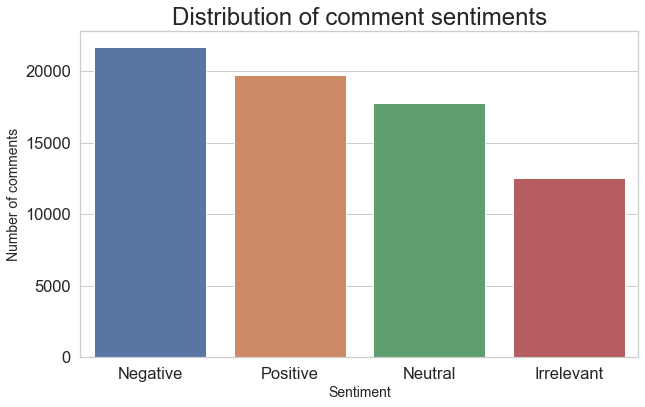

In [120]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid") 
plt.figure(figsize=(10,6))

sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
plt.title("Distribution of comment sentiments", fontsize=24)
plt.ylabel("Number of comments", fontsize=14)
plt.xlabel("Sentiment", fontsize=14)

plt.show()

### Encode sentiments

In [121]:
data["positive"] = 0
data["negative"] = 0
data["neutral"] = 0
data["irrelevant"] = 0
data.loc[data["sentiment"].str.lower() == "positive", ["positive"]] = 1
data.loc[data["sentiment"].str.lower() == "negative", ["negative"]] = 1
data.loc[data["sentiment"].str.lower() == "neutral", ["neutral"]] = 1
data.loc[data["sentiment"].str.lower() == "irrelevant", ["irrelevant"]] = 1

In [122]:
data.head()

,user_id,game,sentiment,comment,positive,negative,neutral,irrelevant
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,1,0,0,0
1,2401,Borderlands,Positive,i am coming to the borders and i will kill you...,1,0,0,0
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,1,0,0,0
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,1,0,0,0
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,1,0,0,0


### Check length of comments

In [123]:
boxplot = data.copy()
boxplot["comment_length"] = data.comment.apply(lambda x: len(str(x)))

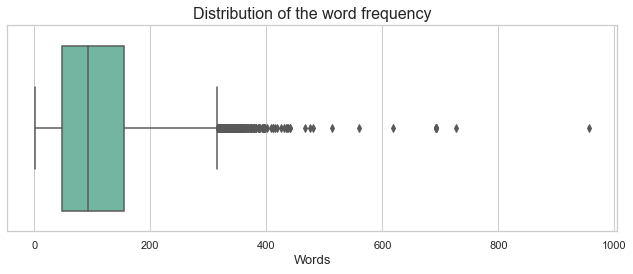

In [124]:
sns.set(style="whitegrid",rc={"font.size":13,"axes.labelsize":13})

plt.figure(figsize=(9, 4))

ax = sns.boxplot(x="comment_length", data=boxplot, orient="h", palette="Set2")
plt.ylabel("")
plt.xlabel("Words")
plt.title("Distribution of the word frequency", fontsize=16)
plt.tight_layout(h_pad=3)

### Visualize most common tokens

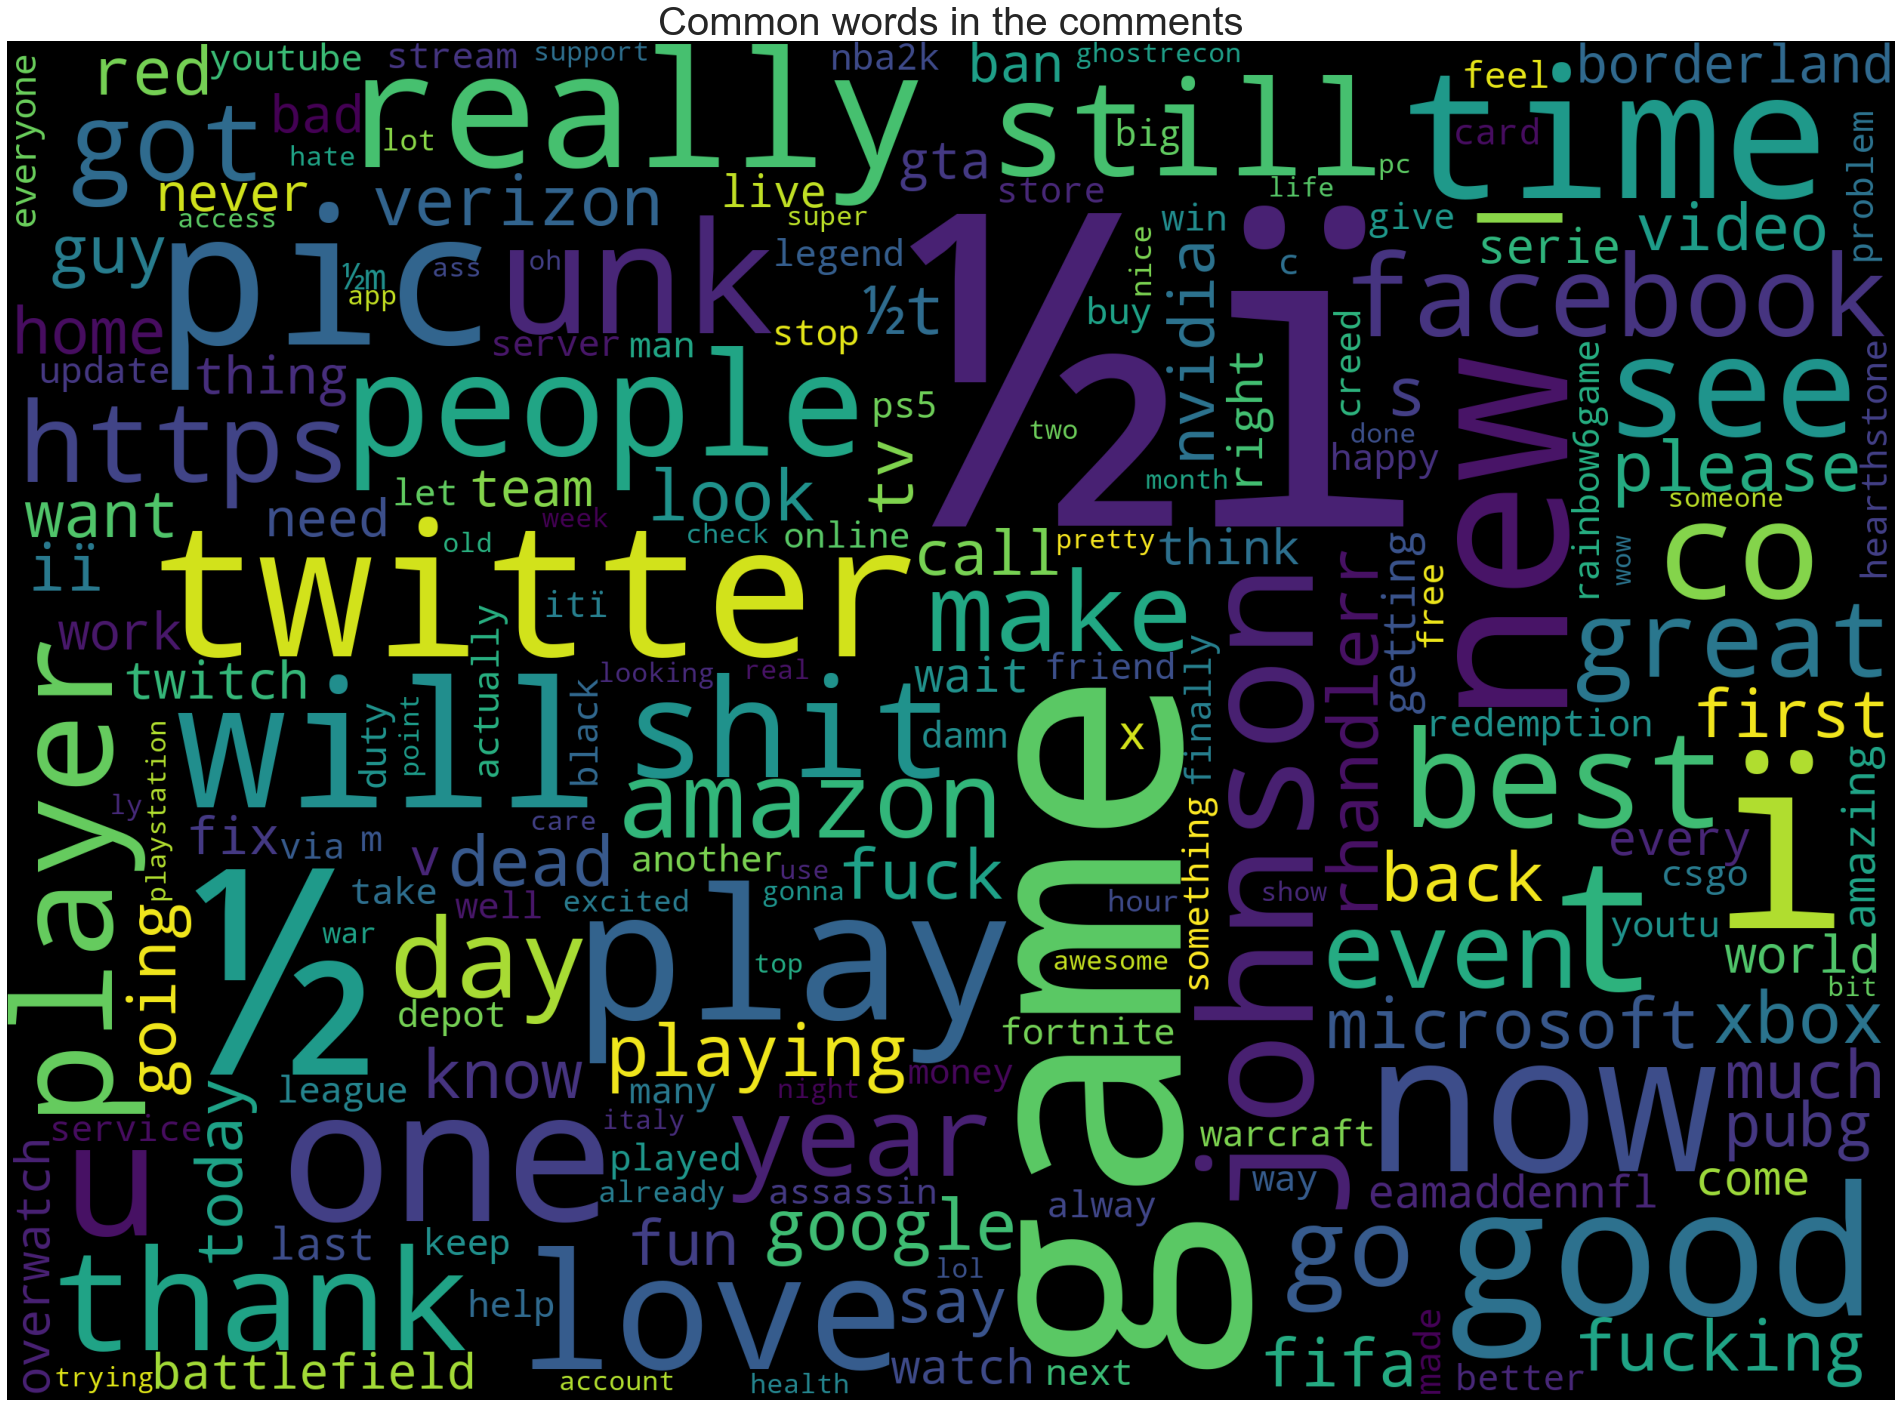

In [125]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(40,25))
data.comment = data.comment.apply(lambda x: str(x))
text = data.comment.values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Common words in the comments",fontsize=40)
plt.imshow(cloud)

# Preprocess

In [126]:
def remove_stop_words(sentence):
    global re_stop_words
    return re_stop_words.sub("", sentence)

def decontract(token):
    token = re.sub(r"won't", "will not", token)
    token = re.sub(r"can\'t", "can not", token)
    token = re.sub(r"n\'t", " not", token)
    token = re.sub(r"\'re", " are", token)
    token = re.sub(r"\'s", " is", token)
    token = re.sub(r"\'d", " would", token)
    token = re.sub(r"\'ll", " will", token)
    token = re.sub(r"\'t", " not", token)
    token = re.sub(r"\'ve", " have", token)
    token = re.sub(r"\'m", " am", token)
    return token

def remove_punctuation(token): 
    token = re.sub(r'[?|!|\'|"|#]',r'',token)
    token = re.sub(r'[.|,|)|(|\|/]',r' ',token)
    token = token.strip()
    token = token.replace("\n"," ")
    return token

In [127]:
stemmer = SnowballStemmer("english")
def stem(token):
    stem_token = ""
    for word in token.split():
        stem = stemmer.stem(word)
        stem_token += stem
        stem_token += " "
    stem_token = stem_token.strip()
    return stem_token

In [128]:
stopwords= set(['br', 'the', 'i', 'im', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

In [129]:
data.comment = data.comment.apply(lambda x: decontract(x))
data.comment = data.comment.apply(remove_stop_words)
data.comment = data.comment.apply(remove_punctuation)
data["comment"] = data.comment.apply(stem)
data.head()

,user_id,game,sentiment,comment,positive,negative,neutral,irrelevant
0,2401,Borderlands,Positive,get borderland murder,1,0,0,0
1,2401,Borderlands,Positive,come border kill,1,0,0,0
2,2401,Borderlands,Positive,get borderland kill,1,0,0,0
3,2401,Borderlands,Positive,come borderland murder,1,0,0,0
4,2401,Borderlands,Positive,get borderland 2 murder,1,0,0,0


# Modeling

In [132]:
seeds = [3, 6, 97, 65, 1000]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(data["comment"], 
                                                    data[data.columns[4:]],
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    shuffle=True)
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
score = 0
for sentiment in data.columns[4:]:
    print('**Processing {} sentiment...**'.format(sentiment))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(X_train, y_train[sentiment])
    
    prediction = LR_pipeline.predict(X_test)
    score = score + roc_auc_score(y_test[sentiment], prediction)
    print('AUC ROC score is {}'.format(roc_auc_score(y_test[sentiment],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(score/len(data.columns[4:])))

**Processing positive sentiment...**
AUC ROC score is 0.779908152266018


**Processing negative sentiment...**
AUC ROC score is 0.8364872216194835


**Processing neutral sentiment...**
AUC ROC score is 0.7302384530215955


**Processing irrelevant sentiment...**
AUC ROC score is 0.601156592326872


Test averaged AUC ROC is 0.7369476048084923


In [135]:
from sklearn.naive_bayes import MultinomialNB

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)))])
score = 0
for sentiment in data.columns[4:]:
    print('**Processing {} sentiment...**'.format(sentiment))
    
    # Training logistic regression model on train data
    NB_pipeline.fit(X_train, y_train[sentiment])
    
    prediction = NB_pipeline.predict(X_test)
    score = score + roc_auc_score(y_test[sentiment], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[sentiment],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(score/len(data.columns[4:])))

**Processing positive sentiment...**
AUC ROC is 0.6714125884428439


**Processing negative sentiment...**
AUC ROC is 0.7604729305986513


**Processing neutral sentiment...**
AUC ROC is 0.6608647551760517


**Processing irrelevant sentiment...**
AUC ROC is 0.5497005273681888


Test averaged AUC ROC is 0.6606127003964339


In [136]:
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))])

score = 0
for sentiment in data.columns[4:]:
    print('**Processing {} sentiment...**'.format(sentiment))
    
    # Training logistic regression model on train data
    SVC_pipeline.fit(X_train, y_train[sentiment])
    
    prediction = SVC_pipeline.predict(X_test)
    score = score + roc_auc_score(y_test[sentiment], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[sentiment],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(score/len(data.columns[4:])))

**Processing positive sentiment...**
AUC ROC is 0.9276407613698088


**Processing negative sentiment...**
AUC ROC is 0.9420490267634379


**Processing neutral sentiment...**
AUC ROC is 0.9224390331529051


**Processing irrelevant sentiment...**
AUC ROC is 0.9183529087167176


Test averaged AUC ROC is 0.9276204325007174


In [138]:
accuracy_results = pd.DataFrame(columns=["MultiOutputClassifier", "OneVsRestClassifier"])
auc_results = pd.DataFrame(columns=["MultiOutputClassifier", "OneVsRestClassifier"])
f1_results = pd.DataFrame(columns=["MultiOutputClassifier", "OneVsRestClassifier"])

for seed in seeds:
    print("Seed: {}".format(seed))
    accuracy_result = []
    auc_result = []
    f1_result = []

    X_train, X_test, y_train, y_test = train_test_split(data["comment"], 
                                                        data[data.columns[4:]],
                                                        test_size=0.3, 
                                                        random_state=seed, 
                                                        shuffle=True)
    vectorizer = TfidfVectorizer(strip_accents="unicode", analyzer="word", ngram_range=(1,3), norm="l2")
    vectorizer.fit(X_train)

    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)

    clf = MultiOutputClassifier(KNeighborsClassifier()).fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print("Accuracy for MultiOutputClassifier is {}".format(accuracy_score(y_test, predictions)))
    print("AUC ROC for MultiOutputClassifier is {}".format(roc_auc_score(y_test, predictions)))
    print("F1 score for MultiOutputClassifier is {}".format(f1_score(y_test, predictions, average="micro")))
    accuracy_result.append(accuracy_score(y_test, predictions))
    auc_result.append(roc_auc_score(y_test, predictions))
    f1_result.append(f1_score(y_test, predictions, average="micro"))

    clf = OneVsRestClassifier(LogisticRegression(class_weight="balanced"), n_jobs=-1).fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print("Accuracy for OneVsRestClassifier is {}".format(accuracy_score(y_test, predictions)))
    print("AUC ROC for OneVsRestClassifier is {}".format(roc_auc_score(y_test, predictions)))
    print("F1 score for OneVsRestClassifier is {}".format(f1_score(y_test, predictions, average="micro")))
    accuracy_result.append(accuracy_score(y_test, predictions))
    auc_result.append(roc_auc_score(y_test, predictions))
    f1_result.append(f1_score(y_test, predictions, average="micro"))

    accuracy_results.loc[seed] = accuracy_result
    auc_results.loc[seed] = auc_result
    f1_results.loc[seed] = f1_result

Seed: 3
Accuracy for MultiOutputClassifier is 0.5332187325775878
AUC ROC for MultiOutputClassifier is 0.7415029172886042
F1 score for MultiOutputClassifier is 0.64374456628432
Accuracy for OneVsRestClassifier is 0.7331351049990708
AUC ROC for OneVsRestClassifier is 0.8956255034747218
F1 score for OneVsRestClassifier is 0.8232442348008385
Seed: 6
Accuracy for MultiOutputClassifier is 0.5194666418881249
AUC ROC for MultiOutputClassifier is 0.7363471029780942
F1 score for MultiOutputClassifier is 0.6340771826353249


/Users/rodolfo.saldanha/Desktop/sentiment_analysis_challenge/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for OneVsRestClassifier is 0.7304404385801896
AUC ROC for OneVsRestClassifier is 0.8927073792778899
F1 score for OneVsRestClassifier is 0.822103902364206
Seed: 97
Accuracy for MultiOutputClassifier is 0.5297342501393792
AUC ROC for MultiOutputClassifier is 0.7390442649747402
F1 score for MultiOutputClassifier is 0.6401482188473739


/Users/rodolfo.saldanha/Desktop/sentiment_analysis_challenge/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rodolfo.saldanha/Desktop/sentiment_analysis_challenge/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solve

Accuracy for OneVsRestClassifier is 0.7298829213900762
AUC ROC for OneVsRestClassifier is 0.8918092308376644
F1 score for OneVsRestClassifier is 0.8192660550458715
Seed: 65
Accuracy for MultiOutputClassifier is 0.5315461810072477
AUC ROC for MultiOutputClassifier is 0.740309153415248
F1 score for MultiOutputClassifier is 0.642446022966561


/Users/rodolfo.saldanha/Desktop/sentiment_analysis_challenge/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for OneVsRestClassifier is 0.7323917487455863
AUC ROC for OneVsRestClassifier is 0.8934109635638031
F1 score for OneVsRestClassifier is 0.821586578474747
Seed: 1000
Accuracy for MultiOutputClassifier is 0.5320572384315183
AUC ROC for MultiOutputClassifier is 0.7392968668255148
F1 score for MultiOutputClassifier is 0.64061757055352


/Users/rodolfo.saldanha/Desktop/sentiment_analysis_challenge/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for OneVsRestClassifier is 0.7335532428916558
AUC ROC for OneVsRestClassifier is 0.8948390277154115
F1 score for OneVsRestClassifier is 0.8245875745875746


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression


clf = ClassifierChain(LogisticRegression()).fit(X_train, y_train)
predictions = clf.predict(X_test)

print('AUC ROC is {}'.format(roc_auc_score(y_test,predictions.toarray())))

: 

: 

In [139]:
accuracy_results.mean()

MultiOutputClassifier    0.529205
OneVsRestClassifier      0.731881
dtype: float64

In [140]:
auc_results.mean()

MultiOutputClassifier    0.739300
OneVsRestClassifier      0.893678
dtype: float64

In [141]:
f1_results.mean()

MultiOutputClassifier    0.640207
OneVsRestClassifier      0.822158
dtype: float64

### Hyper-parameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from datetime import datetime

st = datetime.now()
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty=["l1", "l2"]
params  = {"estimator__C": alpha,
           "estimator__penalty": penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight="balanced"), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring="f1_micro", n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train, y_train)
print("Time taken to perform hyperparameter tuning: ", datetime.now() - st)
print("Best estimator: ", rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ", rsearch_cv.best_score_)

/Users/rodolfo.saldanha/Desktop/sentiment_analysis_challenge/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rodolfo.saldanha/Desktop/sentiment_analysis_challenge/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solve

Time taken to perform hyperparameter tuning:  0:02:19.583766
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=100,
                                                 class_weight='balanced'),
                    n_jobs=-1)
Best Cross Validation Score:  0.8806467607984274
